In [13]:
# CELL 1 - SETUP & MOUNT
from pathlib import Path
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
from google.colab import drive
drive.mount('/content/drive')
data_dir = Path('/content/drive/MyDrive/Thesis/wnts_hourly')
import glob
csv_files = sorted(glob.glob(str(data_dir / '*.csv')))
print("Found csv files:", len(csv_files))
if len(csv_files)>0:
    print("First 5:", [Path(p).name for p in csv_files[:5]])

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found csv files: 9
First 5: ['2013.csv', '2014.csv', '2015.csv', '2016.csv', '2017.csv']


In [14]:
# CELL 2 - LOAD CSVs (robust), set datetime index, concat
import pandas as pd
import numpy as np

def find_datetime_col(cols):
    candidates = ['datetime','timestamp','time','date','Date','DATE','Time','TIMESTAMP']
    for c in candidates:
        if c in cols:
            return c
    for c in cols:
        if 'time' in c.lower() or 'date' in c.lower():
            return c
    return None

def safe_read_csv(path):
    try:
        sample = pd.read_csv(path, nrows=5)
    except Exception as e:
        return None, f"read error: {e}"
    dtcol = find_datetime_col(sample.columns)
    if dtcol is None:
        try:
            df = pd.read_csv(path)
            # try parse index as datetime
            try:
                df.index = pd.to_datetime(df.index)
                df.index.name = 'datetime'
            except:
                return None, "no datetime column and index not parseable"
        except Exception as e:
            return None, f"full read error: {e}"
    else:
        try:
            df = pd.read_csv(path, parse_dates=[dtcol])
            df = df.rename(columns={dtcol: 'datetime'})
            df = df.set_index('datetime')
        except Exception as e:
            return None, f"parse_dates error: {e}"
    return df, None

frames = []
errors = []
for p in csv_files:
    df, err = safe_read_csv(p)
    if err:
        errors.append((p, err))
        continue
    frames.append(df)

print("files loaded:", len(frames), "errors:", len(errors))
for e in errors[:5]:
    print(e)

if len(frames) == 0:
    raise RuntimeError("No files successfully loaded. Check CSVs and datetime columns.")

df_all = pd.concat(frames).sort_index()
df_all = df_all[~df_all.index.duplicated(keep='first')]
print("Concatenated shape:", df_all.shape)
display(df_all.head())

files loaded: 9 errors: 0
Concatenated shape: (73378, 20)


,ASSET_ID,PRESSURE,TEMPERATURE,ENERGY_RATE,VOLUME_RATE,C1,C2,C3,IC4,NC4,IC5,NC5,C6,C7,C8,C9,N2,CO2,H2O,HCDP
datetime,,,,,,,,,,,,,,,,,,,,
2012-12-13 00:00:00,133001,1505.175781,120.46875,177.550934,163.788620,NaN,5.348007,1.328276,0.410411,0.280780,0.174892,0.082553,0.102777,0.060473,0.022702,0.003291,0.180915,2.088464,0.016012,NaN
2012-12-13 01:00:00,133001,1506.103516,120.46875,176.981979,163.378265,NaN,5.349405,1.323484,0.402085,0.263513,0.174039,0.082315,0.102217,0.059929,0.022256,0.003275,0.180925,2.089853,0.015758,NaN
2012-12-13 02:00:00,133001,1506.250000,120.46875,177.613983,163.930695,NaN,5.353745,1.325572,0.402531,0.264127,0.174870,0.083104,0.102677,0.060576,0.023130,0.003288,0.180788,2.092629,0.015857,NaN
2012-12-13 03:00:00,133001,1506.640625,120.46875,178.064575,164.160812,NaN,5.350167,1.330148,0.410774,0.281958,0.175345,0.082869,0.102785,0.060579,0.022856,0.003284,0.180853,2.087186,0.015288,NaN
2012-12-13 04:00:00,133001,1507.666016,120.46875,177.771912,163.980194,NaN,5.350801,1.331701,0.410990,0.281588,0.174554,0.082885,0.102627,0.060293,0.022604,0.003325,0.180913,2.090067,0.015088,NaN


Columns: ['ASSET_ID', 'PRESSURE', 'TEMPERATURE', 'ENERGY_RATE', 'VOLUME_RATE', 'C1', 'C2', 'C3', 'IC4', 'NC4', 'IC5', 'NC5', 'C6', 'C7', 'C8', 'C9', 'N2', 'CO2', 'H2O', 'HCDP']
Index freq (inferred): None
Numeric columns: ['ASSET_ID', 'PRESSURE', 'TEMPERATURE', 'ENERGY_RATE', 'VOLUME_RATE', 'C1', 'C2', 'C3', 'IC4', 'NC4', 'IC5', 'NC5', 'C6', 'C7', 'C8', 'C9', 'N2', 'CO2', 'H2O', 'HCDP']

--- Basic stats ---


,count,mean,std,min,25%,50%,75%,max
ASSET_ID,73378.0,133027.335359,31.629295,133001.000000,133002.000000,133004.000000,133070.000000,133071.000000
PRESSURE,73378.0,1151.163808,540.342074,-1000.000000,590.080688,1414.129883,1519.431885,52555.316406
TEMPERATURE,73378.0,91.856707,607.865423,-37.500000,78.287933,83.660164,99.687500,63662.351562
ENERGY_RATE,72901.0,141.131912,356.932493,0.000000,65.650688,112.583893,203.157349,91865.320312
VOLUME_RATE,72901.0,131.324867,238.193349,0.000000,62.604370,103.939102,188.592865,58108.214844
C1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
C2,73378.0,7.516050,536.793326,0.000000,3.851535,4.882599,5.826396,102832.515625
C3,73378.0,10.134627,868.971923,0.000000,0.739900,1.443529,2.316956,89009.515625
IC4,73378.0,0.516722,0.810136,0.000000,0.220168,0.466148,0.685973,74.553818
NC4,73378.0,13.007153,914.340852,0.000000,0.140785,0.322354,0.537518,66346.992188


/tmp/ipython-input-1564846275.py:23: RuntimeWarning: All-NaN slice encountered
  diag.append((c, float(np.nanmin(vals)), float(np.nanmax(vals)), n_unique, int(n_zero), int(n_na)))


,col,min,max,n_unique,count_zero,count_na
5,C1,NaN,NaN,0,0,73378
19,HCDP,-16.864374,73.370735,2939,499,69420
3,ENERGY_RATE,0.000000,91865.320312,67801,3232,477
4,VOLUME_RATE,0.000000,58108.214844,67662,3238,477
2,TEMPERATURE,-37.500000,63662.351562,40078,2067,0
1,PRESSURE,-1000.000000,52555.316406,27580,2427,0
0,ASSET_ID,133001.000000,133071.000000,7,0,0
6,C2,0.000000,102832.515625,65705,1918,0
8,IC4,0.000000,74.553818,65766,1919,0
9,NC4,0.000000,66346.992188,65734,2020,0


Dropping columns with >50% NA: ['C1', 'HCDP']
Dropping constant columns: []
Missing before: 954
Missing after: 0


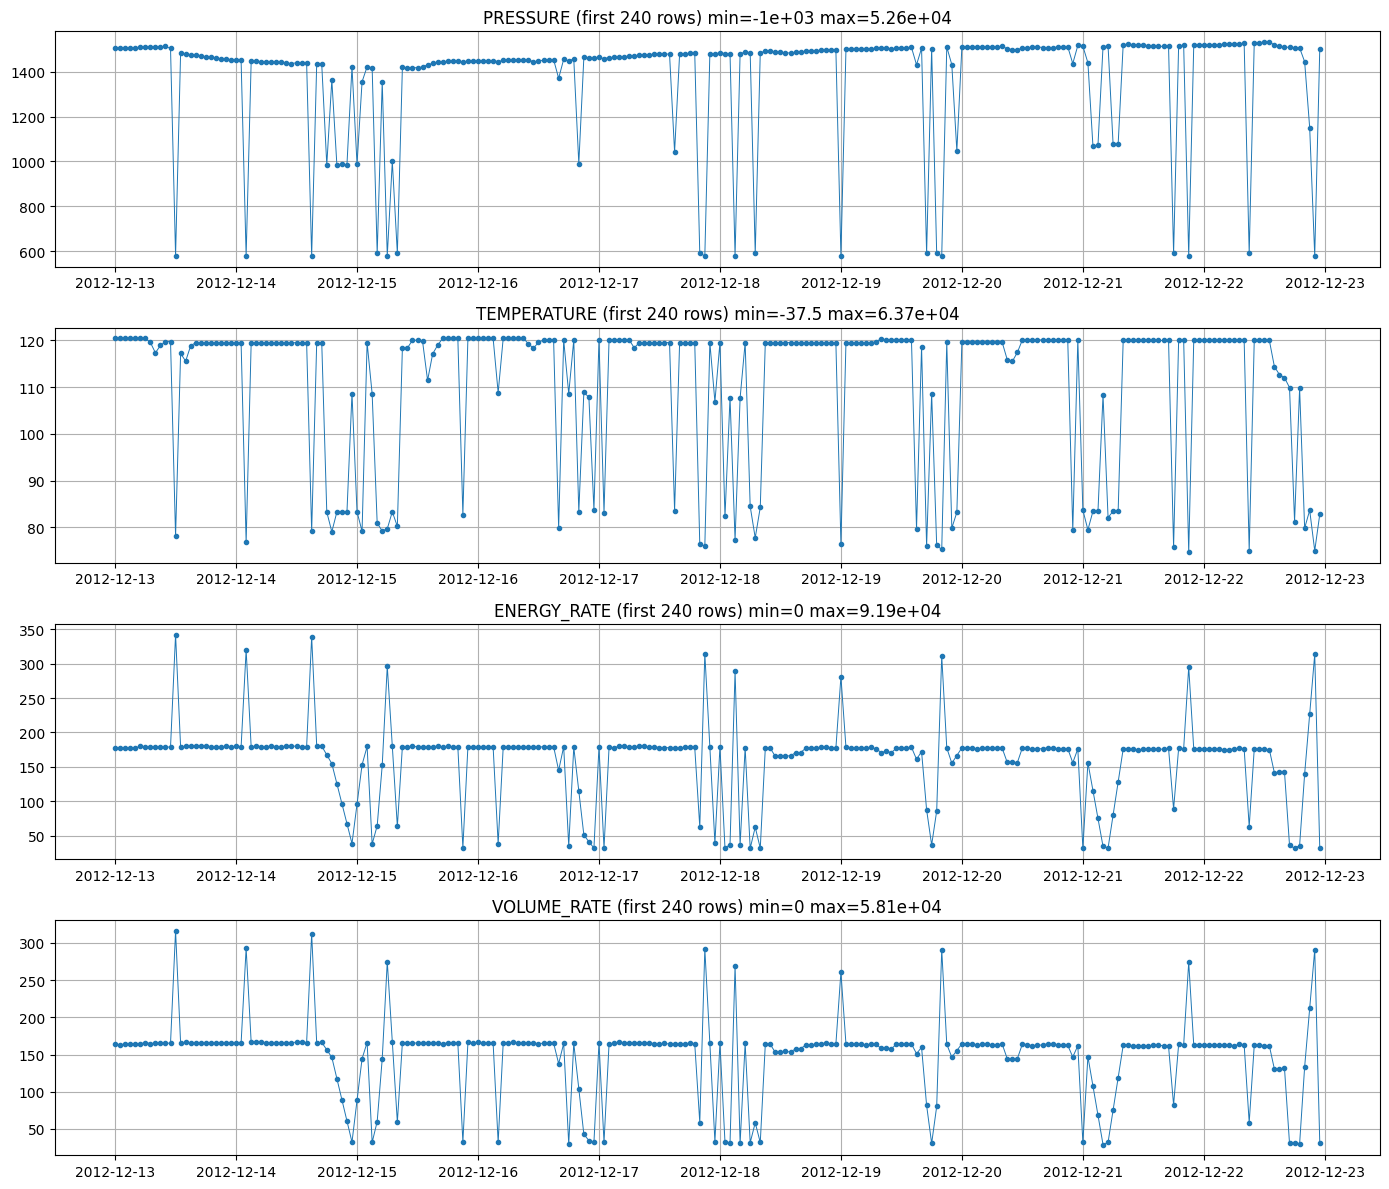

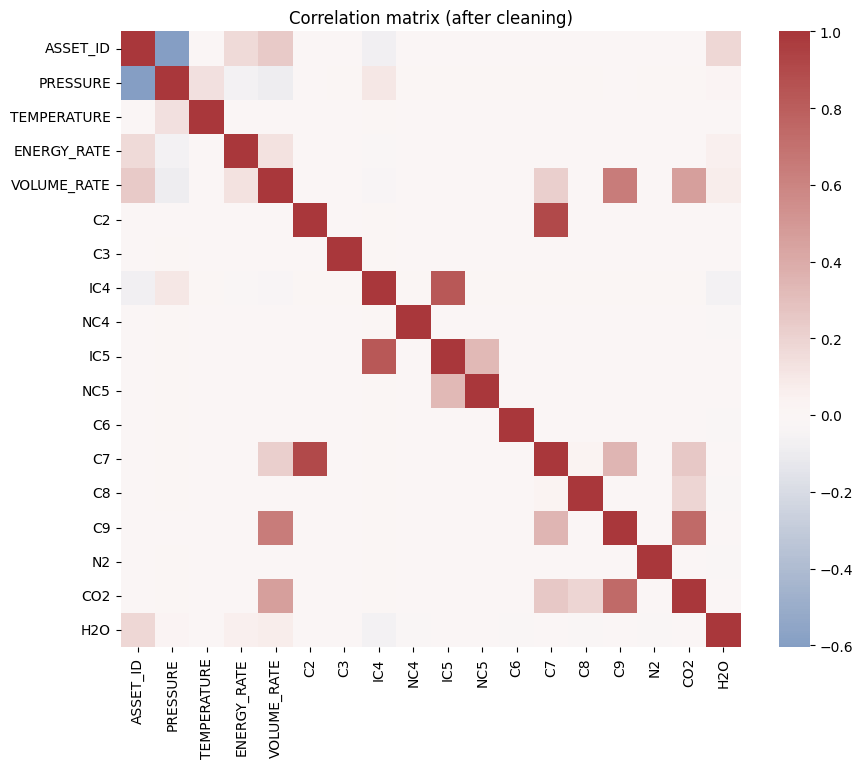

In [15]:
# CELL 3 - DIAGNOSTIC & CLEANING (NO aggressive outlier masking)
import matplotlib.pyplot as plt
import seaborn as sns

print("Columns:", df_all.columns.tolist())
print("Index freq (inferred):", pd.infer_freq(df_all.index))

num_cols = df_all.select_dtypes(include=[np.number]).columns.tolist()
print("Numeric columns:", num_cols)

# Basic diagnostics
print("\n--- Basic stats ---")
display(df_all[num_cols].describe().T)

# Min/max/unique/zero proportion
diag = []
for c in num_cols:
    vals = df_all[c].values
    n = len(vals)
    n_zero = np.sum(vals == 0)
    n_na = np.sum(pd.isna(vals))
    n_unique = np.unique(vals[~pd.isna(vals)]).size
    diag.append((c, float(np.nanmin(vals)), float(np.nanmax(vals)), n_unique, int(n_zero), int(n_na)))
diag_df = pd.DataFrame(diag, columns=['col','min','max','n_unique','count_zero','count_na']).sort_values('count_na', ascending=False)
display(diag_df)

# Drop columns with >50% missing (likely empty)
threshold = 0.5
cols_to_drop = diag_df[diag_df['count_na'] > (threshold * len(df_all))]['col'].tolist()
print("Dropping columns with >50% NA:", cols_to_drop)
df_all = df_all.drop(columns=cols_to_drop, errors='ignore')

# Drop constant columns (n_unique <=1)
num_cols = df_all.select_dtypes(include=[np.number]).columns.tolist()
const_cols = [c for c in num_cols if df_all[c].nunique() <= 1]
print("Dropping constant columns:", const_cols)
df_all = df_all.drop(columns=const_cols, errors='ignore')

# Fill remaining missing with time interpolation then forward/backfill
print("Missing before:", df_all.isna().sum().sum())
df_all = df_all.interpolate(method='time').ffill().bfill()
print("Missing after:", df_all.isna().sum().sum())

# Quick raw plots sample (first 240 rows)
plot_cols = [c for c in ['PRESSURE','TEMPERATURE','ENERGY_RATE','VOLUME_RATE'] if c in df_all.columns]
if len(plot_cols) == 0:
    plot_cols = df_all.select_dtypes(include=[np.number]).columns.tolist()[:4]
n = min(240, len(df_all))
plt.figure(figsize=(14, 3*len(plot_cols)))
for i,c in enumerate(plot_cols):
    plt.subplot(len(plot_cols),1,i+1)
    plt.plot(df_all.index[:n], df_all[c].iloc[:n], marker='.', linewidth=0.7)
    plt.title(f"{c} (first {n} rows) min={df_all[c].min():.3g} max={df_all[c].max():.3g}")
    plt.grid(True)
plt.tight_layout()
plt.show()

# correlation heatmap for valid numeric columns
num_cols = df_all.select_dtypes(include=[np.number]).columns.tolist()
if len(num_cols) > 1:
    plt.figure(figsize=(10,8))
    sns.heatmap(df_all[num_cols].corr(), cmap='vlag', center=0)
    plt.title("Correlation matrix (after cleaning)")
    plt.show()
else:
    print("Not enough numeric columns for correlation heatmap.")

In [16]:
# CELL 4 - FEATURE ENGINEERING (hourly), prepare features list
from sklearn.preprocessing import StandardScaler
import json
import joblib
import numpy as np

# standardize column names to uppercase for consistency
df_all.columns = [c.strip().upper() for c in df_all.columns]

# choose target and features
target = 'PRESSURE'
if target not in df_all.columns:
    target = [c for c in df_all.columns if 'PRESSURE' in c]
    if len(target) == 0:
        raise RuntimeError("No PRESSURE column found. Columns: " + ", ".join(df_all.columns))
    target = target[0]

# numeric features only, exclude target
numeric_cols = df_all.select_dtypes(include=[np.number]).columns.tolist()
features = [c for c in numeric_cols if c != target]

# create lags and rolling features adapted to hourly data
for c in features.copy():  # iterate on copy since new cols are added
    df_all[f'{c}_LAG1'] = df_all[c].shift(1)
    df_all[f'{c}_DIFF1'] = df_all[c].diff().fillna(0)
    df_all[f'{c}_RMEAN_24'] = df_all[c].rolling(window=24, min_periods=1).mean()
    df_all[f'{c}_RSTD_24'] = df_all[c].rolling(window=24, min_periods=1).std().fillna(0)

# time features
df_all['HOUR'] = df_all.index.hour
df_all['DAYOFWEEK'] = df_all.index.dayofweek
df_all['SIN_HOUR'] = np.sin(2*np.pi*df_all['HOUR']/24)
df_all['COS_HOUR'] = np.cos(2*np.pi*df_all['HOUR']/24)

# final features filter: numeric and no all-NA
final_numeric = df_all.select_dtypes(include=[np.number]).columns.tolist()
final_features = [c for c in final_numeric if c != target and df_all[c].isna().sum() == 0]
print("Final features count:", len(final_features))
print("Some features:", final_features[:30])

# drop any remaining rows with NA (edge cases)
df_all = df_all.dropna()

# train-test split by time (80/20)
split_idx = int(len(df_all) * 0.8)
train_df = df_all.iloc[:split_idx].copy()
test_df  = df_all.iloc[split_idx:].copy()
print("Train rows:", len(train_df), "Test rows:", len(test_df))

# scaling
scaler_x = StandardScaler()
scaler_y = StandardScaler()
X_train = scaler_x.fit_transform(train_df[final_features])
X_test  = scaler_x.transform(test_df[final_features])
y_train = scaler_y.fit_transform(train_df[[target]])
y_test  = scaler_y.transform(test_df[[target]])

# save scaler and feature list
joblib.dump(scaler_x, '/content/drive/MyDrive/Thesis/scaler_x.save')
joblib.dump(scaler_y, '/content/drive/MyDrive/Thesis/scaler_y.save')
with open('/content/drive/MyDrive/Thesis/features.json','w') as f:
    json.dump(final_features, f)
print("Saved scalers and features list")

Final features count: 72
Some features: ['ASSET_ID', 'TEMPERATURE', 'ENERGY_RATE', 'VOLUME_RATE', 'C2', 'C3', 'IC4', 'NC4', 'IC5', 'NC5', 'C6', 'C7', 'C8', 'C9', 'N2', 'CO2', 'H2O', 'ASSET_ID_DIFF1', 'ASSET_ID_RMEAN_24', 'ASSET_ID_RSTD_24', 'TEMPERATURE_DIFF1', 'TEMPERATURE_RMEAN_24', 'TEMPERATURE_RSTD_24', 'ENERGY_RATE_DIFF1', 'ENERGY_RATE_RMEAN_24', 'ENERGY_RATE_RSTD_24', 'VOLUME_RATE_DIFF1', 'VOLUME_RATE_RMEAN_24', 'VOLUME_RATE_RSTD_24', 'C2_DIFF1']
Train rows: 58701 Test rows: 14676
Saved scalers and features list


In [17]:
# CELL 5 - SEQUENCE CREATION & SAMPLE CHECK
import numpy as np

def create_sequences(X, y, seq_len):
    Xs, Ys = [], []
    for i in range(seq_len, len(X)):
        Xs.append(X[i-seq_len:i])
        Ys.append(y[i])
    return np.array(Xs), np.array(Ys)

# sequence length: for hourly data choose 24 (1 day) or 48 (2 days); use 24 by default
SEQ_LEN = 24
Xtr, ytr = create_sequences(X_train, y_train, SEQ_LEN)
Xte, yte = create_sequences(X_test, y_test, SEQ_LEN)
print("Xtr,ytr shapes:", Xtr.shape, ytr.shape)
print("Xte,yte shapes:", Xte.shape, yte.shape)

# quick sanity: inverse transform one sample target to check scale
import joblib
sc_y = joblib.load('/content/drive/MyDrive/Thesis/scaler_y.save')
print("example y original scale:", sc_y.inverse_transform(ytr[:5]))

Xtr,ytr shapes: (58677, 24, 72) (58677, 1)
Xte,yte shapes: (14652, 24, 72) (14652, 1)
example y original scale: [[1450.1953125 ]
 [ 579.16094971]
 [1446.58203125]
 [1445.65429688]
 [1444.28710938]]


/usr/local/lib/python3.12/dist-packages/jaxlib/plugin_support.py:71: RuntimeWarning: JAX plugin jax_cuda12_plugin version 0.7.2 is installed, but it is not compatible with the installed jaxlib version 0.8.1, so it will not be used.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 24, 64)         │        35,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 48,033 (187.63 KB)

 Trainable params: 48,033 (187.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
 99/104 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.9160 - mae: 0.8062

104/104 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.9214 - mae: 0.8058 - val_loss: 0.5883 - val_mae: 0.6359 - learning_rate: 0.0010
Epoch 2/40
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.1375 - mae: 0.7883 - val_loss: 0.6005 - val_mae: 0.6307 - learning_rate: 0.0010
Epoch 3/40
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.9726 - mae: 0.7852 - val_loss: 0.5932 - val_mae: 0.6316 - learning_rate: 0.0010
Epoch 4/40
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.9049 - mae: 0.7842 - val_loss: 0.6050 - val_mae: 0.6294 - learning_rate: 0.0010
Epoch 5/40
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.9147 - mae: 0.7806 - val_loss: 0.5949 - val_mae: 0.6267 - learning_rate: 0.0010
Epoch 6/40
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.0975 - mae: 0.7809 - val_loss: 0.6006 - val_mae: 0.6278 - learning_rate: 5.0000e-04
Epoch 7/40
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.4467 - mae: 0.7779 - val_loss: 0.5952 - val_mae: 0.6306 - learning_rate: 5.0000e-04
Epoch 8/

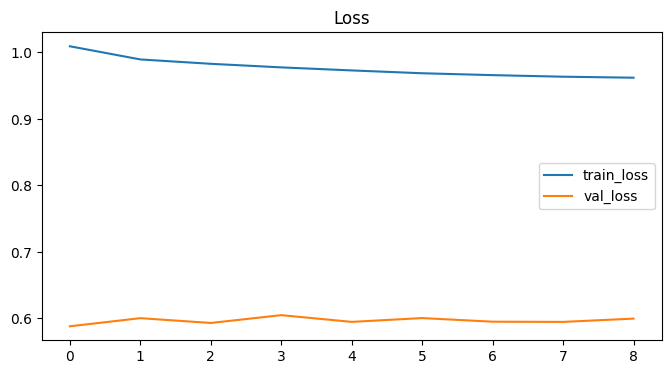

458/458 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
MAE 375.34861750380446
MSE 342330.6652184908
RMSE 585.0903051824486
R2 -0.015487725244602846
MAPE(%) 299979961057.3917


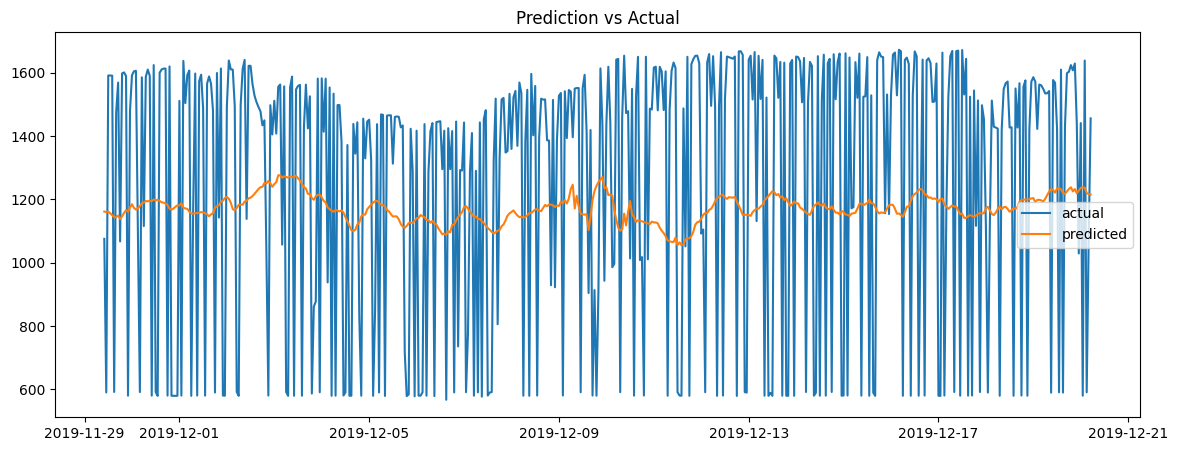

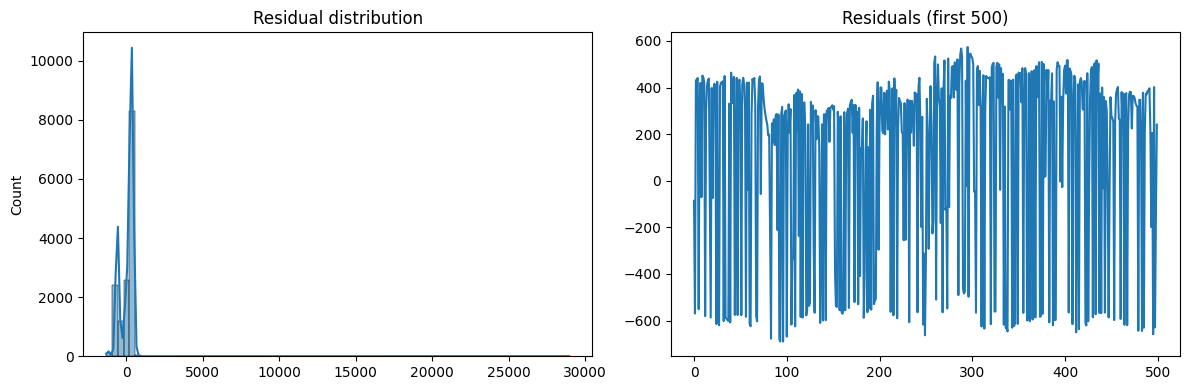

Model and artifacts saved to MyDrive/Thesis/


In [18]:
# CELL 6 - BUILD, TRAIN LSTM, EVALUATE, SAVE
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import joblib
import pandas as pd
import seaborn as sns

tf.keras.backend.clear_session()

model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(Xtr.shape[1], Xtr.shape[2])),
    Dropout(0.2),
    LSTM(32, return_sequences=False),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

es = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
rl = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4)
chk_path = '/content/drive/MyDrive/Thesis/lstm_best.h5'
chk = ModelCheckpoint(chk_path, monitor='val_loss', save_best_only=True)

history = model.fit(Xtr, ytr, validation_split=0.1, epochs=40, batch_size=512, callbacks=[es, rl, chk])

# training curves
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(); plt.title('Loss'); plt.show()

# predictions & inverse transform
sc_y = joblib.load('/content/drive/MyDrive/Thesis/scaler_y.save')
y_pred = model.predict(Xte)
y_pred_inv = sc_y.inverse_transform(y_pred)
yte_inv = sc_y.inverse_transform(yte)

mae = mean_absolute_error(yte_inv, y_pred_inv)
mse = mean_squared_error(yte_inv, y_pred_inv)
rmse = np.sqrt(mse)
r2 = r2_score(yte_inv, y_pred_inv)
mape = np.mean(np.abs((yte_inv - y_pred_inv) / (yte_inv + 1e-9))) * 100

print("MAE", mae)
print("MSE", mse)
print("RMSE", rmse)
print("R2", r2)
print("MAPE(%)", mape)

# plot slice
idx_start = 0
idx_end = min(500, len(yte_inv))
plt.figure(figsize=(14,5))
plt.plot(test_df.index[SEQ_LEN+idx_start:SEQ_LEN+idx_end], yte_inv[idx_start:idx_end], label='actual')
plt.plot(test_df.index[SEQ_LEN+idx_start:SEQ_LEN+idx_end], y_pred_inv[idx_start:idx_end], label='predicted')
plt.legend(); plt.title('Prediction vs Actual'); plt.show()

# residuals
res = (yte_inv - y_pred_inv).flatten()
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.histplot(res, bins=80, kde=True)
plt.title('Residual distribution')
plt.subplot(1,2,2)
plt.plot(res[:500])
plt.title('Residuals (first 500)')
plt.tight_layout()
plt.show()

# save history
pd.DataFrame(history.history).to_csv('/content/drive/MyDrive/Thesis/training_history.csv', index=False)
print("Model and artifacts saved to MyDrive/Thesis/")